In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import root_scalar
import matplotlib.cm as cm
from scipy.optimize import minimize_scalar
import matplotlib.pylab as pylab

In [4]:
# User inputs are only required for the following 2 boxes. The remained can be run without modification. 
# if modifications are necessary, descriptions are provided to help troubleshooting

# Common errors
# RuntimeWarning: invalid value encountered in double_scalars app.launch_new_instance() 
#       - this can be safely ignored

# UserWarning: Creating legend with loc="best" can be slow with large amounts of data. fig.canvas.print_figure(bytes_io, **kw)
#       - this can be safely ignored 

#UnboundLocalError: local variable 'j' referenced before assignment
#       - some of the chambers in the csv are empty. scroll to the bottom of box 7 and choose the right size of 
#         valve_states to fix it

In [5]:
# Data Required

###
# name of the file you are reading, assumed to be a csv output file from 3Flex equipment
###

####
# info to modify
data_suffix = '2020-07-10_1229_n-hexane_298K_NU-1000_UiO-66-GlassBeads'
####
data = np.genfromtxt(f'{data_suffix}.csv', delimiter=',')

In [6]:
# Data Required


# Chamber_select - choose which sample chamber to study, 0,1,2 corresponds to the first, second, third chamber
# L_scale - particle size in meters, assuming 3 sample ports
L_scale = [4e-6, 4e-6, 4e-6]
# divide by 2 to make radius
L_scale = [L/2 for L in L_scale]

# max pressure - upper limit of pressure to consider - assuming mmHg
max_pressure = [2., 2., 2.]

# V_D - Manifold volume - cm^3
V_D = 25.531

# choose which sample chamber to solve for - remember Python starts from 0. 
# if 3 sample ports the choices are port 0, port 1, port 2
Chamber_select = 0

In [7]:
########################
#
# automatically reading the different chambers from the equipment, should not need modifying
#

man_pressure = data[:,0]
time = data[:,3]
time = time - time[0]
time /= 1000
U_pressures = [data[:,4], data[:,22], data[:,40]]

valves = [data[:,14], data[:,32], data[:,50]]

Q_sets = [data[:,11], data[:,29], data[:,47]]

# V_Us = [data[0,10], data[0,28], data[0,46]]
V_Us = [data[0,5], data[0,23], data[0, 41]]


C:\Users\Brandon\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


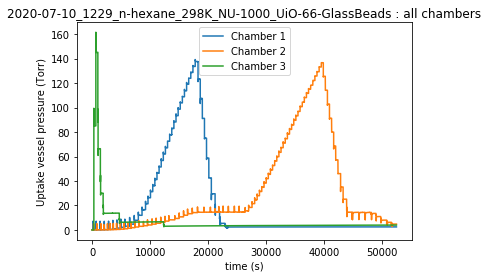

In [8]:
#
# simple plot showing the pressure profile in the manifold over the full run
#
plt.plot(time, U_pressures[0])
plt.plot(time, U_pressures[1])
plt.plot(time, U_pressures[2])
plt.title(f'{data_suffix} : all chambers')
plt.ylabel('Uptake vessel pressure (Torr)')
plt.xlabel('time (s)')
plt.legend(['Chamber 1', 'Chamber 2', 'Chamber 3'])
#plt.ylim(0,400)


In [9]:
##
# helper function to determine when the valve are open and closed
##

def valve_states(valve):
    valve_indices = list(np.where(valve != 0))[0]
    index_jump_list = []
    valve_state = []
    for i, index in enumerate(valve_indices[1:]):
        if valve_indices[i] - valve_indices[i-1] != 1:
            index_jump_list.append(i)
    for j in range(len(index_jump_list) - 1):
        valve_state.append(valve_indices[index_jump_list[j]:index_jump_list[j+1]])
    valve_state.append(valve_indices[index_jump_list[j+1]:-1])
    return valve_state

valve_states = [valve_states(valves[0]), valve_states(valves[1]), valve_states(valves[2])]
#valve_states = [valve_states(valves[0]), valve_states(valves[1])]
#valve_states = [valve_states(valves[0])]

In [10]:
##
# function to determine the root-mean-square error between the experimental function (ex) and simulated function (h)
## 

def RMS_calc(h, ex):
    return np.sqrt(np.sum((h[2:] - ex[2:])**2) / h[2:].size)

In [11]:
####
# Split the data into individual runs based on whether the valves are open or closed. 
# No user input necessary
####


P_U_0_overall = []
P_D_0_overall = []
P_inf_overall = []
P_U_0_set = []
P_D_0_set = []
P_inf_set = []
P_close = []
scale_time_zip = []
time_zip = []
uptake_zip = []
P_U_overall = []
P_D_overall = []
V_S_set = []
Q_set = []
P_Ds = []
P_Us = []
CJ = Chamber_select
for j, vlv_group in enumerate(valve_states[CJ][:]):
    dml = (Q_sets[CJ][vlv_group]-Q_sets[CJ][vlv_group[0]-1]) / (Q_sets[CJ][vlv_group[-1]] - Q_sets[CJ][vlv_group[0]-1])
    if dml[0] < 0.1 and dml[0] > -0.1 and np.all(dml < 1.05) and np.all(dml > -0.05):
        if U_pressures[CJ][vlv_group[0]-1] < max_pressure[CJ]:
            P_D = man_pressure[vlv_group]
            P_inf = U_pressures[CJ][vlv_group][-1]
            if P_D[0]-P_inf > 0:
                P_Ds.append(man_pressure[vlv_group])
                P_Us.append(U_pressures[CJ][vlv_group])
                P_D_0_set.append(man_pressure[vlv_group[0]-1])
                P_U_0_set.append(U_pressures[CJ][vlv_group[0]-1])
                P_inf_set.append(man_pressure[vlv_group][-1])
                time_zip.append(time[vlv_group] - time[vlv_group][0])
                scale_time_zip.append(time[vlv_group] - time[vlv_group][0])         
                dml = (Q_sets[CJ][vlv_group]-Q_sets[CJ][vlv_group[0]-1]) / (Q_sets[CJ][vlv_group[-1]] - Q_sets[CJ][vlv_group[0]-1])
                Q_set.append(Q_sets[CJ][vlv_group]- Q_sets[CJ][vlv_group[0]-1])
                V_S_set.append(Q_sets[CJ][vlv_group[-1]]- Q_sets[CJ][vlv_group[0]-1])
                uptake_zip.append(dml)

<Figure size 432x288 with 0 Axes>

<Figure size 864x864 with 0 Axes>

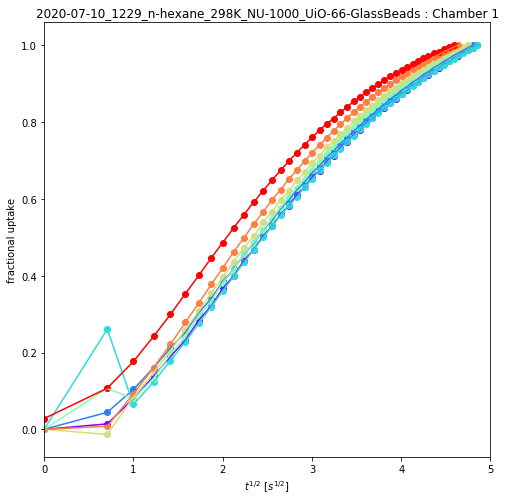

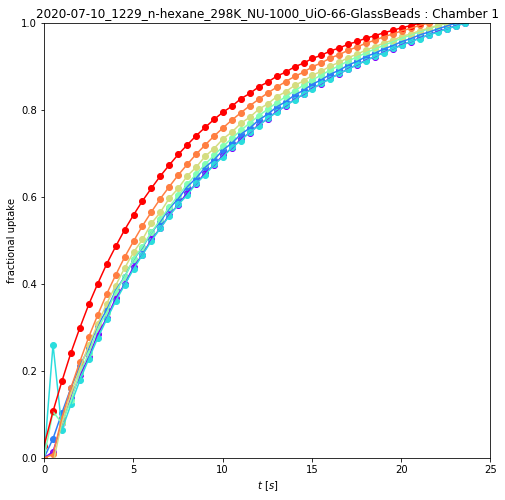

In [12]:
##
# plot the pressure in the uptake cell when the valves are opened
##

plt.figure()
plt.figure(figsize=(12,12))
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0,1,len(uptake_zip)))
def sequential_color_plot(intensity_data, position_data, colors=colors, data_suffix=data_suffix):
    fig, ax = plt.subplots(figsize=(8,8))
    for i, c in zip(range(len(intensity_data)), colors):
        ax.plot(np.sqrt(position_data[i]), intensity_data[i], color=c)
        ax.scatter(np.sqrt(position_data[i]), intensity_data[i], color=c)
    #ax.set_ylim(0,1)
    ax.set_title(f'{data_suffix} : Chamber {Chamber_select+1}')
    ax.set_xlim(0,5)
    ax.set_xlabel('$t^{1/2}$ [$s^{1/2}$]')
    ax.set_ylabel('fractional uptake')
sequential_color_plot(uptake_zip[:], scale_time_zip[:])
def sequential_color_plot(intensity_data, position_data, colors=colors, data_suffix=data_suffix):
    fig, ax = plt.subplots(figsize=(8,8))
    for i, c in zip(range(len(intensity_data)), colors):
        ax.plot(position_data[i], intensity_data[i], color=c)
        ax.scatter(position_data[i], intensity_data[i], color=c)
    ax.set_title(f'{data_suffix} : Chamber {Chamber_select+1}')
    ax.set_ylim(0,1)
    ax.set_xlim(0,25)
    ax.set_xlabel('$t$ [$s$]')
    ax.set_ylabel('fractional uptake')
sequential_color_plot(uptake_zip[:], time_zip[:])

In [13]:
####
# combined surface + intracrysalline objective function to minimze
####

def objective_function_comb(x0, uptake_bundle):
    # requires - x0, initial guess for D_R and a_LDF : uptake bundle, parameters for solver
    # returns - RMS, error between analytical solution and experimental data
    
    # D_R = dimensionless intracrystalline diffusion coefficient
    D_R = x0[0] 
    # a_LDF = ratio between surface diffusion rate and intracrystalline diffusion rate - alpha_LDF
    a_LDF = x0[1]
 
    # pulling parameters from the bundle
    # delta_gamma = delta and gamma determined from the fraction of moles in manifold / uptake cell
    # pressure_bundle = set of initial and pressures- see below
    # tau_times = experimental timesteps (s)
    # scaled_time = timesteps for simulated values
    # sig_D = sigma_D - experimental reduced pressure in the dosing volume
    # omega_c = intrinsic valve constant that depends on the instument
    # M = how many terms of the solution series we use
    delta_gamma, pressure_bundle, tau_times, scaled_time, sig_D, omega_c, M = uptake_bundle
    
    # omega = the true valve constant
    omega = omega_c / D_R

    RMS = 0
    # analytical solution 
    analytical = combined_diffusion(omega, D_R, delta_gamma, a_LDF, pressure_bundle, scaled_time, M)

    # calculate RMS between analytical and experimental values
    RMS = RMS_calc(analytical[:], sig_D[:])
    
    return(RMS)

In [14]:
#######
# The combined diffusion function from Brandani
#######

def combined_diffusion(omega, D_R, delta_gamma, a_LDF, pressure_bundle, times, M):
    delta, gamma = delta_gamma
    P_D_0, P_U_0, P_inf = pressure_bundle
      
    Beta_set = []
    z_set = []
    a_set = []

    def f(x, valve_bundle):
        gamma, delta, omega, a_LDF = valve_bundle
        z = 1 + ((a_LDF*(gamma*x**2*(omega-x**2) + omega*delta*x**2)) / ((omega-x**2)*(a_LDF-gamma*x**2)-omega*delta*x**2))
        return (x/np.tan(x))-z
  
    valve_bundle = [gamma, delta, omega, a_LDF] 

    a_q = gamma #a*c + b + d
    b_q = -omega*gamma-a_LDF-omega*delta # a*c - b - d
    c_q = omega*a_LDF    
    
    LB_wall = np.pi
    window = 1
    while len(Beta_set) < M:
        LB = window * LB_wall + 1e-8
        UB = (window + 1) * LB_wall - 1e-8
        root_out = scipy.optimize.root_scalar(f, valve_bundle, bracket=[LB, UB], method='brentq', xtol=1e-12, rtol=1e-12)
        Beta_set.append(root_out.root)
        window += 1
        
    root1_old = np.sqrt((-b_q-np.sqrt((b_q**2)-4*a_q*c_q))/(2*a_q))
    left_window = np.floor(root1_old / np.pi)
    #print(f"unrefined root: {root1_old}")
    trivial_root = scipy.optimize.root_scalar(f, valve_bundle, bracket=[left_window*np.pi + 1e-8, (left_window+1)*np.pi - 1e-8], method='brentq', xtol=1e-12, rtol=1e-12)
    base_root = trivial_root.root
    #print(f"trivial root: {base_root}")
    root_error = np.inf
    start = left_window*np.pi + 1e-8
    #print(f"guess root {root1_old}")

    if base_root < root1_old:
        try: 
            br_1 = scipy.optimize.root_scalar(f, valve_bundle, bracket=[left_window*np.pi+ 1e-8, base_root - 1e-8], method='brentq', xtol=1e-12, rtol=1e-12)
            good_root = br_1.root
        except ValueError:
            pass

        try: 
            br_2 = scipy.optimize.root_scalar(f, valve_bundle, bracket=[base_root + 1e-8, root1_old - 1e-8], method='brentq', xtol=1e-12, rtol=1e-12)
            good_root = br_2.root
        except ValueError:
            pass

        try: 
            br_3 = scipy.optimize.root_scalar(f, valve_bundle, bracket=[root1_old + 1e-8, (left_window+1)*np.pi - 1e-8], method='brentq', xtol=1e-12, rtol=1e-12)
            good_root = br_3.root
        except ValueError:
            pass

# -----------------------------------------------

    elif root1_old < base_root:
        try: 
            br_1 = scipy.optimize.root_scalar(f, valve_bundle, bracket=[left_window*np.pi+ 1e-12, root1_old - 1e-12], method='brentq', xtol=1e-12, rtol=1e-12)
            good_root = br_1.root
        except ValueError:
            pass

        try: 
            br_2 = scipy.optimize.root_scalar(f, valve_bundle, bracket=[root1_old + 1e-12, base_root - 1e-12], method='brentq', xtol=1e-12, rtol=1e-12)
            good_root = br_2.root
        except ValueError:
            pass

        try: 
            br_3 = scipy.optimize.root_scalar(f, valve_bundle, bracket=[base_root + 1e-12, (left_window+1)*np.pi - 1e-12], method='brentq', xtol=1e-12, rtol=1e-12)
            good_root = br_3.root
        except ValueError:
            pass
                  
    Beta_set.append(good_root)
    
    #print(" ------------------- ")

    root2_old = np.sqrt((-b_q+np.sqrt((b_q**2)-4*a_q*c_q))/(2*a_q))
    left_window = np.floor(root2_old / np.pi)
    trivial_root = scipy.optimize.root_scalar(f, valve_bundle, bracket=[left_window*np.pi + 1e-12, (left_window+1)*np.pi - 1e-12], method='brentq', xtol=1e-12, rtol=1e-12)
    base_root = trivial_root.root
    root_error = np.inf
    start = left_window*np.pi + 1e-8

    if base_root < root2_old:
        try: 
            br_1 = scipy.optimize.root_scalar(f, valve_bundle, bracket=[left_window*np.pi+ 1e-8, base_root - 1e-8], method='brentq', xtol=1e-12, rtol=1e-12)
            good_root = br_1.root
        except ValueError:
            pass

        try: 
            br_2 = scipy.optimize.root_scalar(f, valve_bundle, bracket=[base_root + 1e-8, root2_old - 1e-8], method='brentq', xtol=1e-12, rtol=1e-12)
            good_root = br_2.root
        except ValueError:
            pass

        try: 
            br_3 = scipy.optimize.root_scalar(f, valve_bundle, bracket=[root2_old + 1e-8, (left_window+1)*np.pi - 1e-8], method='brentq', xtol=1e-12, rtol=1e-12)
            good_root = br_3.root
        except ValueError:
            pass

# -----------------------------------------------

    elif root2_old < base_root:
        try: 
            br_1 = scipy.optimize.root_scalar(f, valve_bundle, bracket=[left_window*np.pi+ 1e-8, root2_old - 1e-8], method='brentq', xtol=1e-12, rtol=1e-12)
            good_root = br_1.root
        except ValueError:
            pass

        try: 
            br_2 = scipy.optimize.root_scalar(f, valve_bundle, bracket=[root2_old + 1e-8, base_root - 1e-8], method='brentq', xtol=1e-12, rtol=1e-12)
            good_root = br_2.root
        except ValueError:
            pass

        try: 
            br_3 = scipy.optimize.root_scalar(f, valve_bundle, bracket=[base_root + 1e-8, (left_window+1)*np.pi - 1e-8], method='brentq', xtol=1e-12, rtol=1e-12)
            good_root = br_3.root
        except ValueError:
            pass
                
                    
    Beta_set.append(good_root)    
    Beta_set = np.array(Beta_set)
 
    def z_fun(Beta, gamma, delta, omega, a_LDF):
        z = 1 + ((a_LDF*(gamma*Beta**2*(omega-Beta**2) + omega*delta*Beta**2)) / ((omega-Beta**2)*(a_LDF-gamma*Beta**2)-omega*delta*Beta**2))            
        return z
    z_set = z_fun(Beta_set, gamma, delta, omega, a_LDF)

    def a_fun(Beta, gamma, delta, omega, z, a_LDF):
        b2 = Beta**2
        gb2 = gamma*b2
        od = omega*delta
        odb2 = od*b2
        T1 = (z-1)*(od-gb2+a_LDF) + a_LDF*(od-gb2)
        T2 = ((omega-b2)*(a_LDF-gb2)-odb2) / (2*b2)
        T3 = (z**2 + b2 - z)
        T4 = (z - 1) * (a_LDF+gamma*(omega-b2) - gb2 + od)
        T5 =  a_LDF*(gamma*(omega-b2)-gb2+od)

        return T1/(T2*T3+T4+T5)
    a_set = a_fun(Beta_set, gamma, delta, omega, z_set, a_LDF)

    #print(f"total a_set sum {np.sum(a_set)}")
    
    pre_factor = (3*delta) / (1 + 3*delta + 3*gamma)
    y_intra = []
    for new_time in times:
        cumulant = pre_factor
        for i in range(len(Beta_set)):
            #print(a_set[i]+pre_factor)
            cumulant += a_set[i] * np.exp(-(Beta_set[i]**2)*D_R*new_time)
        y_intra.append(cumulant)
    #print(y_intra[0])
    rho_D_0 =(P_D_0 - P_U_0) / (P_inf - P_U_0) # 3.61 / 1.4
    rho_D_intra = np.asarray(y_intra) * rho_D_0
    sig_D_intra = (rho_D_intra *(P_inf-P_U_0)+P_U_0-P_inf) / (P_D_0-P_inf)
    
    return sig_D_intra

C:\Users\Brandon\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


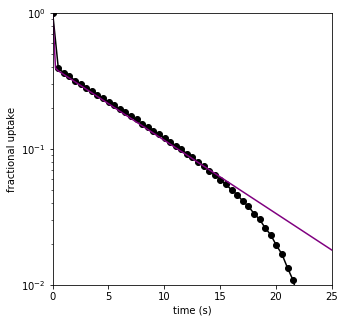

Equilibrium pressure (mmHg) 1.3616
Intracrystalline diffusion coefficient (m2s-1) 1.246241897194329e-12
Surface barrier (ms-1) 1.537271944415937e-08
RMS error 0.009581896738972773


C:\Users\Brandon\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


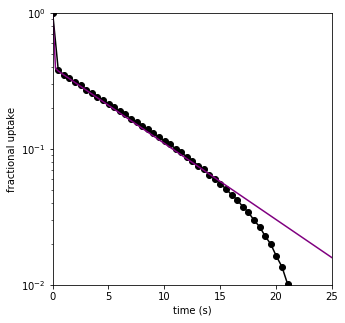

Equilibrium pressure (mmHg) 1.4093
Intracrystalline diffusion coefficient (m2s-1) 1.2390207426934774e-12
Surface barrier (ms-1) 1.6277912684573024e-08
RMS error 0.008579033745792048


C:\Users\Brandon\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


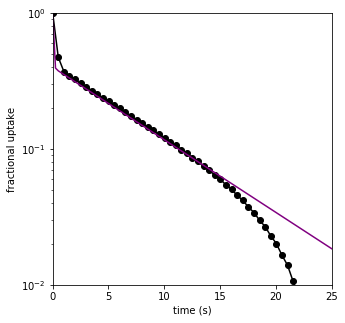

Equilibrium pressure (mmHg) 1.4128
Intracrystalline diffusion coefficient (m2s-1) 1.2324265224172017e-12
Surface barrier (ms-1) 1.529920020712689e-08
RMS error 0.010486137786234561


C:\Users\Brandon\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


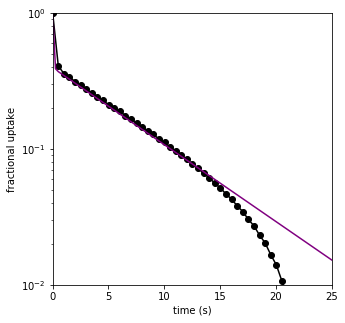

Equilibrium pressure (mmHg) 1.6805
Intracrystalline diffusion coefficient (m2s-1) 1.3885928936892516e-12
Surface barrier (ms-1) 1.7424667817510916e-08
RMS error 0.009615171764911846


C:\Users\Brandon\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


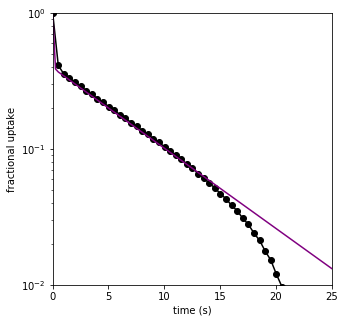

Equilibrium pressure (mmHg) 1.9829
Intracrystalline diffusion coefficient (m2s-1) 1.483901235994943e-12
Surface barrier (ms-1) 1.8596075361770012e-08
RMS error 0.008628198123642086


C:\Users\Brandon\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


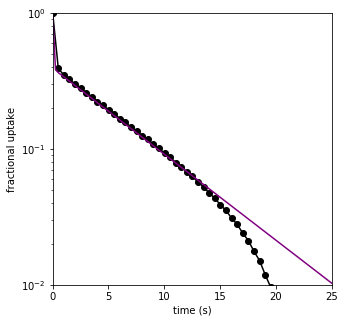

Equilibrium pressure (mmHg) 2.4889
Intracrystalline diffusion coefficient (m2s-1) 1.59542486359409e-12
Surface barrier (ms-1) 2.0867625798659526e-08
RMS error 0.007930268984625123


C:\Users\Brandon\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


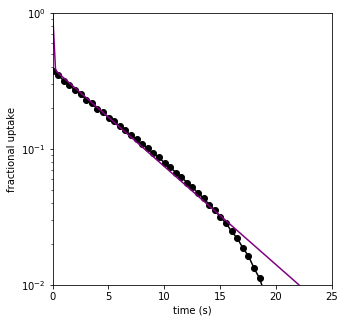

Equilibrium pressure (mmHg) 3.0618
Intracrystalline diffusion coefficient (m2s-1) 3.6550366863184444e-13
Surface barrier (ms-1) 2.430776067035023e-08
RMS error 0.00611371954344382


In [15]:
D_R_set = []
aLDF_set = []
omega_set = []
omega_LDF = []
rms_set = []
rms2_set = []
P_U_0_check = []
P_inf_check = []
P_D_0_check = []
expts_data = []
timeset_data = []
fitted_data = []
D_R_overall = []
aLDF_overall = []
rms_overall = []

for exp in range(len(P_U_0_set[:])):
    #it = 0
    plt.figure(figsize=(5,5))


    P_D_0 = P_D_0_set[exp] #[index_jump_list[0]]-1]
    P_U_0 = P_U_0_set[exp] #[index_jump_list[0]]-1]
    P_inf = P_inf_set[exp]
    P_D = P_Ds[exp]
    P_U = P_Us[exp]
    V_U = V_Us[CJ]
    #print(V_U)
    V_S = V_S_set[exp]
    time_cut = time_zip[exp]
    sig_D = (P_D - P_inf) / (P_D_0 - P_inf)
    #print(time_cut)
    plt.scatter(time_cut, sig_D, c='k')
    plt.plot(time_cut, sig_D, c='k')
    expts_data.append(sig_D)
    timeset_data.append(time_cut)
    plt.yscale('log')
    plt.ylabel('fractional uptake')
    plt.xlabel('time (s)')
    plt.ylim(0.01, 1)
    plt.xlim(0,25)

    #######################################################
    # These are some initial conditions for the solver, can be modified if the fits are poor.
    # M is the number of terms in the transcendental tan function. Can be increased if needed.

    omega_c = 10
    M = 100
    D_R_list = [0.1]
    a_LDF_list = [0.001]
    #
    #######################################################    


    tau_times = np.linspace(0,25,100)
    kai = (P_inf - P_U_0) / (P_D_0 - P_U_0)
    eps = V_U/V_D
    delt_temp = -kai / (3*kai+3*eps*kai-3)

    gam_temp = delt_temp * eps
    delta_gamma = [delt_temp, gam_temp]
    new_preex = 3*delt_temp / (1+3*delt_temp+3*gam_temp)

    pressure_bundle = [P_D_0, P_U_0, P_inf]
    
    ratio_set = np.array(D_R_list) * np.array(a_LDF_list)

    uptake_bundle = [delta_gamma, pressure_bundle, tau_times, time_cut, sig_D, omega_c, M]
    rms_test = np.inf
  
    for i in range(len(D_R_list)):
        x0 = [D_R_list[i], a_LDF_list[i]]        
        comb_solv = scipy.optimize.minimize(objective_function_comb, x0, args=uptake_bundle, method='Nelder-Mead', options={'xatol':1e-4, 'fatol':1e-4}) #})
        rms = comb_solv['fun']        
        if rms < rms_test:
            rms_test = rms
            D_R = comb_solv['x'][0]
            a_LDF = comb_solv['x'][1]
            k_r = a_LDF * D_R
            omega = omega_c / D_R
            
 
    D_R_set.append(D_R)

    aLDF_set.append(a_LDF)
    P_U_0_check.append(P_U_0)
    P_inf_check.append(P_inf) 
    P_D_0_check.append(P_D_0)

    sig_D_comb = combined_diffusion(omega, D_R, delta_gamma, a_LDF, pressure_bundle, tau_times, M)
    plt.plot(tau_times, sig_D_comb, c='purple')
    fitted_data.append(sig_D_comb)
    plt.show()

    print(f"Equilibrium pressure (mmHg) {P_inf}")
    print(f"Intracrystalline diffusion coefficient (m2s-1) {D_R*L_scale[Chamber_select]**2}")
    print(f"Surface barrier (ms-1) {a_LDF*D_R*L_scale[Chamber_select]}")
    print(f"RMS error {rms}")

D_R_overall.append(D_R_set)
aLDF_overall.append(aLDF_set)
rms_overall.append(rms_set)
P_U_0_overall.append(P_U_0_check)
P_D_0_overall.append(P_D_0_check)
P_inf_overall.append(P_inf_check)

In [16]:
D_R_overall_clean = []
P_U_0_overall_clean = []
P_inf_overall_clean = []
P_D_0_overall_clean = []
aLDF_overall_clean = []
for i in range(1):
    D_R_clean = []
    P_U_0_clean = []
    aLDF_clean = []
    P_inf_clean = []
    P_D_0_clean = []
    for j in range(len(D_R_overall[i])):
        D_R_clean.append(D_R_overall[i][j])
        P_U_0_clean.append(P_U_0_overall[i][j])
        P_D_0_clean.append(P_D_0_overall[i][j])
        P_inf_clean.append(P_inf_overall[i][j])
        aLDF_clean.append(aLDF_overall[i][j])
    D_R_overall_clean.append(D_R_clean)
    P_U_0_overall_clean.append(P_U_0_clean)
    P_D_0_overall_clean.append(P_D_0_clean)
    P_inf_overall_clean.append(P_inf_clean)
    aLDF_overall_clean.append(aLDF_clean)

Remember to cite Brandani, S.; Brandani, F.; Mangano, E.; Pullumbi, P. Using a Volumetric Apparatus to Identify and Measure the Mass Transfer Resistance in Commercial Adsorbents. Microporous and Mesoporous Materials 2020, 304, 109277.


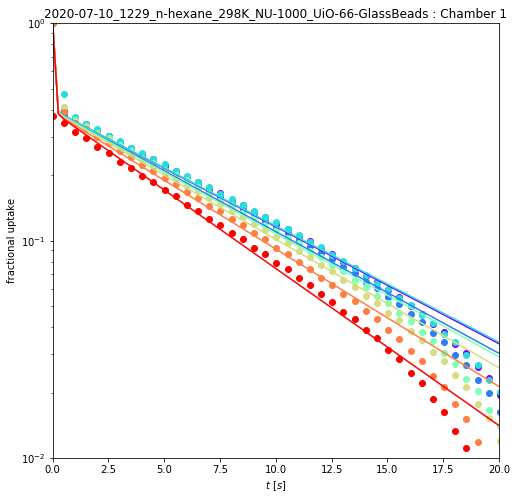

In [17]:
fitted_data
expts_data
fitted_data
colors = cm.rainbow(np.linspace(0,1,len(uptake_zip)))
def sequential_color_plot(intensity_data, position_data, fit_data, colors=colors, data_suffix=data_suffix):
    plt.figure(figsize=(8,8))
    for i, c in zip(range(len(intensity_data)), colors):
        plt.scatter(position_data[i], intensity_data[i], color=c)
        plt.plot(tau_times, fit_data[i], color=c)
    plt.title(f'{data_suffix} : Chamber {Chamber_select+1}')
    plt.yscale('log')
    plt.ylim(1e-2, 1)
    plt.xlim(0, 20)
    plt.xlabel('$t$ [$s$]')
    plt.ylabel('fractional uptake')
sequential_color_plot(expts_data[:], timeset_data[:], fitted_data[:])


print("Remember to cite Brandani, S.; Brandani, F.; Mangano, E.; Pullumbi, P. Using a Volumetric Apparatus to Identify and Measure the Mass Transfer Resistance in Commercial Adsorbents. Microporous and Mesoporous Materials 2020, 304, 109277.")

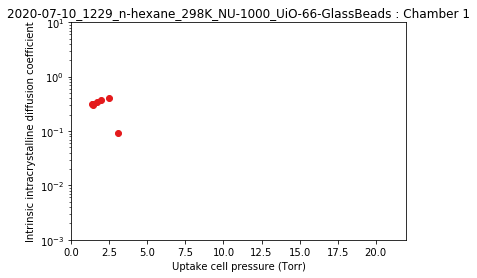

In [18]:
import matplotlib.cm as cm
colors = cm.Set1(np.linspace(0,1,len(P_U_0_overall_clean)))

def sequential_color_plot(intensity_data, position_data, colors=colors, data_suffix=data_suffix):
    fig, ax = plt.subplots()
    for i, c in zip(range(len(intensity_data)), colors):
        ax.scatter(position_data[i], intensity_data[i], color=c)
    ax.set_title(f'{data_suffix} : Chamber {Chamber_select+1}')
    ax.set_xlabel('Uptake cell pressure (Torr)')
    ax.set_ylabel('Intrinsic intracrystalline diffusion coefficient')
    plt.yscale("log")
    plt.ylim(0.001, 10)
    plt.xlim(0, max_pressure[Chamber_select]+20)
sequential_color_plot(D_R_overall_clean, P_inf_overall_clean)

#######################
#
# plot of dimensionless intracrystalline diffusion coefficients against the chamber cell pressure
#
#######################

In [19]:
print("Intrinsic intracrystalline diffusivity\n")
print("Pressure (Torr)  /  D/R^2 (s^-1)\n")
for i in range(len(D_R_overall_clean[0])):
    print(f"{P_inf_overall_clean[0][i]} {D_R_overall_clean[0][i]}")

Intrinsic intracrystalline diffusivity

Pressure (Torr)  /  D/R^2 (s^-1)

1.3616 0.31156047429858225
1.4093 0.30975518567336935
1.4128 0.30810663060430044
1.6805 0.3471482234223129
1.9829 0.37097530899873576
2.4889 0.3988562158985225
3.0618 0.09137591715796112


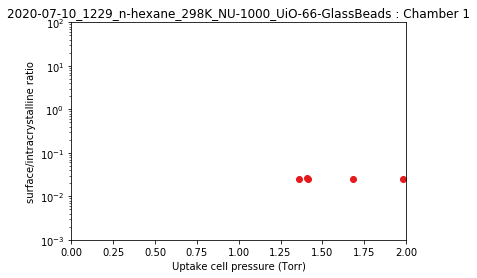

In [20]:
import matplotlib.cm as cm
colors = cm.Set1(np.linspace(0,1,len(P_U_0_overall_clean)))
#uptake_zip = uptake_zip[0]
#time_zip = time_zip[0]
def sequential_color_plot(intensity_data, position_data, colors=colors, data_suffix=data_suffix):
    fig, ax = plt.subplots()
    for i, c in zip(range(len(intensity_data)), colors):
        ax.scatter(position_data[i], intensity_data[i], color=c)
    ax.set_title(f'{data_suffix} : Chamber {Chamber_select+1}')
    ax.set_xlabel('Uptake cell pressure (Torr)')
    ax.set_ylabel('surface/intracrystalline ratio')
    plt.yscale("log")
    plt.ylim(0.001, 100)
    plt.xlim(0, max_pressure[Chamber_select])
sequential_color_plot(aLDF_overall_clean, P_inf_overall_clean)

#######################
#
# plot of ratio between intracrystalline diffusion coefficients and surface barriers against the chamber cell pressure
#
#######################

In [21]:
print("Surface / intracrystalline ratio\n")
print("Pressure (Torr)  /  alpha_LDF\n")
for i in range(len(aLDF_overall_clean[0])):
    print(f"{P_inf_overall_clean[0][i]} {aLDF_overall_clean[0][i]}")

Surface / intracrystalline ratio

Pressure (Torr)  /  alpha_LDF

1.3616 0.024670522598811764
1.4093 0.026275448220805186
1.4128 0.024827768518191295
1.6805 0.025096870215454703
1.9829 0.025063764232666746
2.4889 0.02615933382365626
3.0618 0.13300966724268015


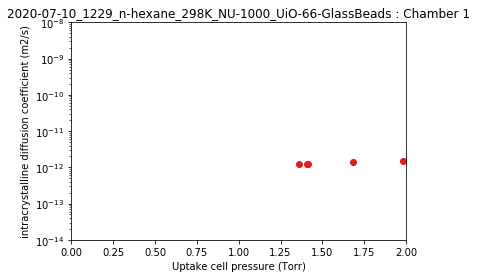

In [22]:
import matplotlib.cm as cm
colors = cm.Set1(np.linspace(0,1,len(P_U_0_overall_clean)))
#uptake_zip = uptake_zip[0]
#time_zip = time_zip[0]
def sequential_color_plot(intensity_data, position_data, colors=colors, data_suffix=data_suffix):
    fig, ax = plt.subplots()
    for i, c in zip(range(len(intensity_data)), colors):
        ax.scatter(position_data[i], np.array(intensity_data[i])*(L_scale[Chamber_select]**2), color=c)
    ax.set_title(f'{data_suffix} : Chamber {Chamber_select+1}')
    ax.set_xlabel('Uptake cell pressure (Torr)')
    ax.set_ylabel('intracrystalline diffusion coefficient (m2/s)')
    plt.yscale("log")
    plt.ylim(1e-14, 1e-8)
    plt.xlim(0, max_pressure[Chamber_select])
sequential_color_plot(D_R_overall_clean, P_inf_overall_clean)

#######################
#
# plot of intracrystalline diffusion coefficients against the chamber cell pressure
#
#######################

In [23]:
print("Intracrystalline diffusivity\n")
print("Pressure (Torr)  /  D (m^2 / s) \n")
for i in range(len(D_R_overall_clean[0])):
    print(f"{P_inf_overall_clean[0][i]} {D_R_overall_clean[0][i]*L_scale[Chamber_select]**2}")

Intracrystalline diffusivity

Pressure (Torr)  /  D (m^2 / s) 

1.3616 1.246241897194329e-12
1.4093 1.2390207426934774e-12
1.4128 1.2324265224172017e-12
1.6805 1.3885928936892516e-12
1.9829 1.483901235994943e-12
2.4889 1.59542486359409e-12
3.0618 3.6550366863184444e-13


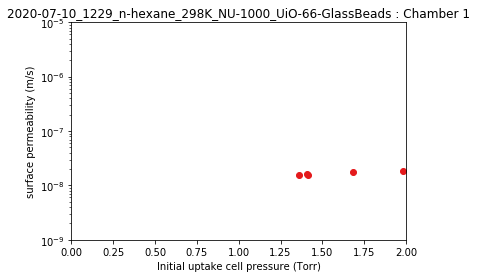

In [24]:
import matplotlib.cm as cm
colors = cm.Set1(np.linspace(0,1,len(P_U_0_overall_clean)))
def sequential_color_plot(intensity_data, position_data, colors=colors, data_suffix=data_suffix):
    fig, ax = plt.subplots()
    for i, c in zip(range(len(intensity_data)), colors):
        big_array = np.array(aLDF_overall_clean[i])*np.array(D_R_overall_clean[i])*L_scale[Chamber_select]
        ax.scatter(position_data[i], np.array(big_array), color=c)
    ax.set_title(f'{data_suffix} : Chamber {Chamber_select+1}')
    ax.set_xlabel('Initial uptake cell pressure (Torr)')
    ax.set_ylabel('surface permeability (m/s)')
    plt.yscale("log")
    plt.ylim(1e-9, 1e-5)
    plt.xlim(0, max_pressure[Chamber_select])
sequential_color_plot(aLDF_overall_clean, P_inf_overall_clean)

#######################
#
# plot of the surface permeabilities against the chamber cell pressure
#
#######################

In [25]:
print("Surface barrier\n")
print("Pressure (Torr)  /  k (m / s) \n")
for i in range(len(D_R_overall_clean[0])):
    print(f"{P_inf_overall_clean[0][i]} {aLDF_overall_clean[0][i]*D_R_overall_clean[0][i]*L_scale[Chamber_select]}")

Surface barrier

Pressure (Torr)  /  k (m / s) 

1.3616 1.537271944415937e-08
1.4093 1.6277912684573024e-08
1.4128 1.529920020712689e-08
1.6805 1.7424667817510916e-08
1.9829 1.8596075361770012e-08
2.4889 2.0867625798659526e-08
3.0618 2.430776067035023e-08


In [26]:
print("Intrinsic surface barrier\n")
print("Pressure (Torr)  /  k (1 / s) \n")
for i in range(len(D_R_overall_clean[0])):
    print(f"{P_inf_overall_clean[0][i]} {aLDF_overall_clean[0][i]*D_R_overall_clean[0][i]}")

Intrinsic surface barrier

Pressure (Torr)  /  k (1 / s) 

1.3616 0.007686359722079685
1.4093 0.008138956342286513
1.4128 0.0076496001035634455
1.6805 0.008712333908755459
1.9829 0.009298037680885007
2.4889 0.010433812899329764
3.0618 0.012153880335175116
